In [ ]:
pip install pandas elevation richdem


  Using cached richdem-0.3.4.tar.gz (329 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for richdem: filename=richdem-0.3.4-cp310-cp310-linux_x86_64.whl size=7844532 sha256=52ababc75995faebd8af90f856ebdae9f05259027d23a2967ea66c993e116f22
  Stored in directory: /root/.cache/pip/wheels/01/61/27/5c305116b5cffecf04ed75c40f640e2baf231dae20954e31e0
Successfully built richdem


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
file_paths = [
    '/content/202205-divvy-tripdata.csv',
    '/content/202206-divvy-tripdata.csv',
    '/content/202207-divvy-tripdata.csv',
    '/content/202208-divvy-tripdata.csv',
    '/content/202209-divvy-publictripdata.csv',
    '/content/202210-divvy-tripdata.csv',
    '/content/202211-divvy-tripdata.csv',
    '/content/202212-divvy-tripdata.csv',
    '/content/202301-divvy-tripdata.csv',
    '/content/202302-divvy-tripdata.csv',
    '/content/202303-divvy-tripdata.csv',
    '/content/202304-divvy-tripdata.csv'
]

dfs = []

for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_csv('/content/combined-divvy-tripdata.csv', index=False)

In [3]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/combined-divvy-tripdata.csv')

# Remove rows where any of the latitude or longitude data is missing
df.dropna(subset=['start_lat', 'start_lng', 'end_lat', 'end_lng'], inplace=True)

# Fill missing station names with their ID
df['start_station_name'] = df['start_station_name'].fillna(df['start_station_id'])
df['end_station_name'] = df['end_station_name'].fillna(df['end_station_id'])
df.drop_duplicates(inplace=True)
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df.to_csv('/content/combined-divvy-tripdata.csv', index=False)

In [2]:
import pandas as pd
import elevation
import richdem as rd
import requests

# Function to get elevation given latitude and longitude
def get_elevation(lat, lon):
    url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            elevation_data = response.json()
            if elevation_data and "results" in elevation_data and len(elevation_data["results"]) > 0:
                return elevation_data["results"][0]["elevation"]
            else:
                return None
        else:
            return None
    except Exception as e:
        print(f"Error fetching elevation data: {e}")
        return None

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/combined-divvy-tripdata.csv')

# Calculate start and end elevations for each row
df['start_elevation'] = df.apply(lambda row: get_elevation(row['start_lat'], row['start_lng']), axis=1)
df['end_elevation'] = df.apply(lambda row: get_elevation(row['end_lat'], row['end_lng']), axis=1)

# Save the DataFrame with the elevation data back to a new CSV file
df.to_csv('/content/combined-divvy-tripdata-with-elevation.csv', index=False)


KeyboardInterrupt: 

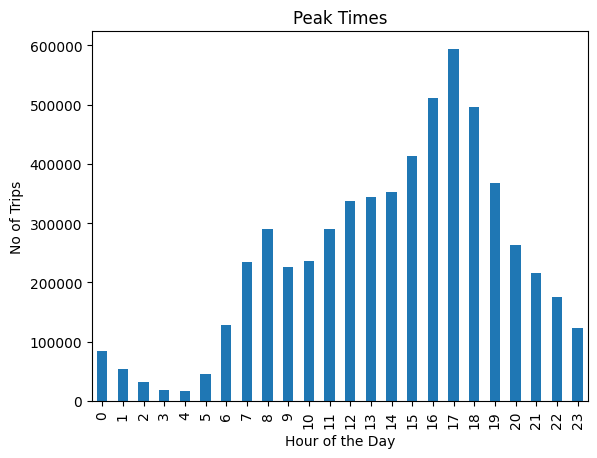

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Show peak usage times
df['hour'] = df['started_at'].dt.hour
peak_usage = df.groupby('hour').size()

# Plot
peak_usage.plot(kind='bar')
plt.title('Peak Times')
plt.xlabel('Hour of the Day')
plt.ylabel('No of Trips')
plt.show()

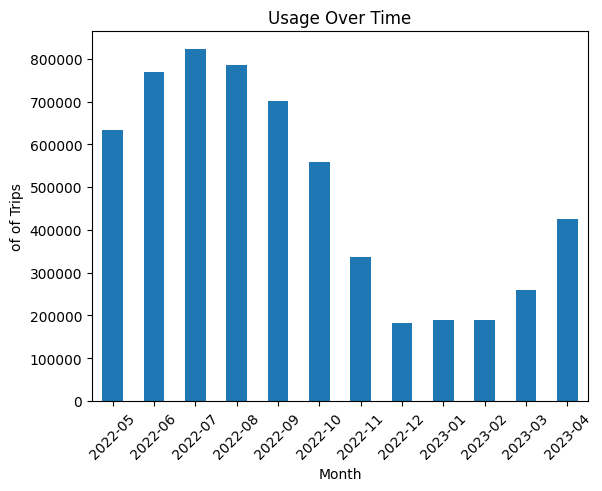

In [6]:
# Normalizing month
df['month'] = df['started_at'].dt.to_period('M')

# No of trips by month
usage_trends = df.groupby('month').size()

# Plot
usage_trends.plot(kind='bar')
plt.title('Usage Over Time')
plt.xlabel('Month')
plt.ylabel('of of Trips')
plt.xticks(rotation=45)
plt.show()

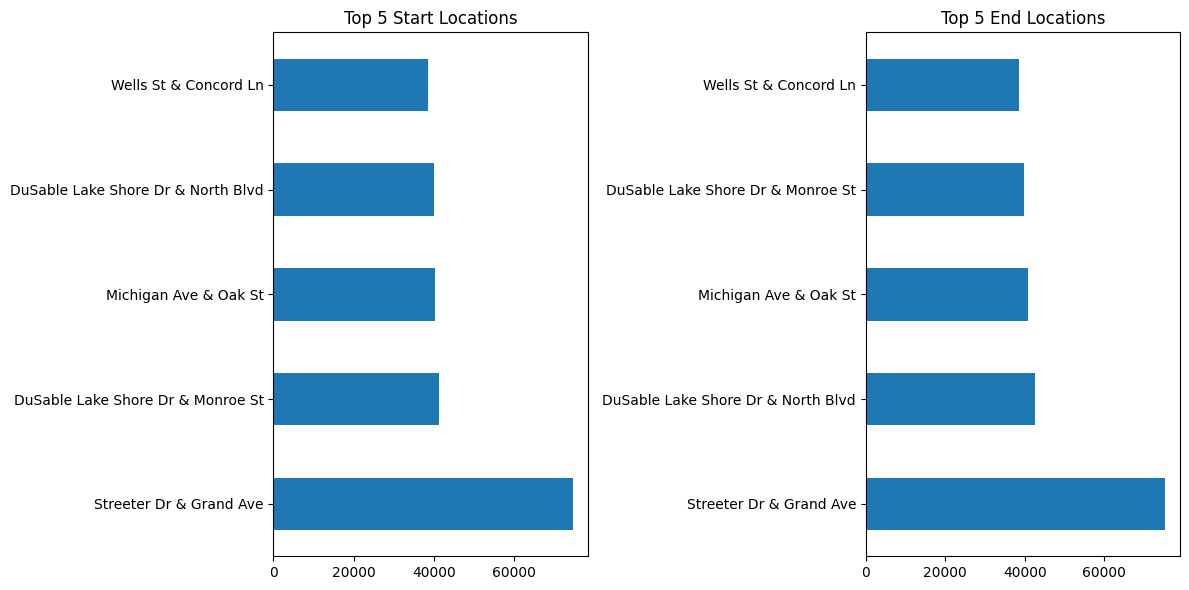

In [7]:
# Top 5 start locations
top_starts = df['start_station_name'].value_counts().head(5)

# Top 5 end locations
top_ends = df['end_station_name'].value_counts().head(5)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
top_starts.plot(kind='barh', ax=axes[0], title='Top 5 Start Locations')
top_ends.plot(kind='barh', ax=axes[1], title='Top 5 End Locations')
plt.tight_layout()
plt.show()

In [9]:
# Convert the trip duration to minutes
df['duration_minutes'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60.0

# Compute the mean duration for trips
mean_duration = df['duration_minutes'].mean()

# Define a function to calculate the distance in kilometers between two points
def haversine_distance_km(row):
    # Haversine formula to calculate distances
    R = 6371  # Radius of the Earth in kilometers
    delta_lat = np.radians(row['end_lat'] - row['start_lat'])
    delta_lon = np.radians(row['end_lng'] - row['start_lng'])
    a = np.sin(delta_lat/2)**2 + np.cos(np.radians(row['start_lat'])) * np.cos(np.radians(row['end_lat'])) * np.sin(delta_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Apply the distance calculation for each trip
df['distance_km'] = df.apply(haversine_distance_km, axis=1)

# Calculate the average distance for trips
mean_distance = df['distance_km'].mean()

print(f'Average Trip Duration: {mean_duration:.2f} minutes')
print(f'Average Trip Distance: {mean_distance:.2f} km')


Average Trip Duration: 15.83 minutes
Average Trip Distance: 2.12 km
